In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import json
import time
import datetime
%matplotlib inline 

<h2>DeepAR - Kaggle Bike Sharing Demand Dataset with Dynamic Features</h2>
<h4>Prepare Bike Rental Data for DeepAR training</h4>  
<quote>We will store the total rental count, registered rental count, and casual rental count data as a time series.</quote>
<quote>For each of the targets <b>total, registered, casual</b>, following JSON is structured as: Start Time, Array of target values, optional dynamic features and categories</quote>
<quote>Frequency of time series data (for example, hourly, daily, monthly and so forth) is specified using hyperparameter</quote>

<h4>To download original dataset, sign-in and download from this link: https://www.kaggle.com/c/bike-sharing-demand/data</h4>
<br>
<b>Dynamic features used</b>: ['Close/Last', 'Volume', 'Open', ' High', 'Low']<br>
       
Start Time From: ['datetime'] <br>
Target Feature: [<b>'count','registered','casual'</b>]<br>
Frequency: daily

In [4]:
dynamic_features = ['Volume', 'Open', 'High', 'Low']
target_values = ['Close/Last']

In [5]:
# Copy over from biketrain_data_preparation

freq='D' # Timeseries consists Daily Data and we need to predict 

# how far in the future predictions can be made
prediction_length = 5 

# aws recommends setting context same as prediction length as a starting point. 
# This controls how far in the past the network can see
context_length = 5

In [6]:
df = pd.read_csv('AAPL.csv', parse_dates=[0],index_col=0)
#df_test = pd.read_csv('test.csv', parse_dates=['datetime'],index_col=0)
df.head()

,Close/Last,Volume,Open,High,Low
Date,,,,,
2020-12-22,$131.88,169351800,$131.61,$134.405,$129.65
2020-12-21,$128.23,121251600,$125.02,$128.31,$123.449
2020-12-18,$126.655,192541500,$128.96,$129.1,$126.12
2020-12-17,$128.7,94359810,$128.9,$129.58,$128.045
2020-12-16,$127.81,98208590,$127.41,$128.37,$126.56


In [7]:
listcol=df.columns.values.tolist()
listcol

[' Close/Last', ' Volume', ' Open', ' High', ' Low']

In [8]:
# Remove $ and strip empty space from column name
#----------------------------------------------------
#df = df[' Open'].apply(lambda x: x.replace('$','') )
#listcol=df.columns.values.tolist()

for col in listcol:
    newcol=col.strip()
    print(col,newcol,df[col].dtypes)
    if df[col].dtypes == 'object':
        df[newcol]=df[col].apply(lambda x: float(x.replace('$','')) )
    else:
        df[newcol]=df[col]
 #drop original columns
    df.drop([col], axis=1,inplace=True)
df.head()    

 Close/Last Close/Last object
 Volume Volume int64
 Open Open object
 High High object
 Low Low object


,Close/Last,Volume,Open,High,Low
Date,,,,,
2020-12-22,131.880,169351800,131.61,134.405,129.650
2020-12-21,128.230,121251600,125.02,128.310,123.449
2020-12-18,126.655,192541500,128.96,129.100,126.120
2020-12-17,128.700,94359810,128.90,129.580,128.045
2020-12-16,127.810,98208590,127.41,128.370,126.560


In [9]:
df_resampled = df.resample('1d').mean()
# fill in all missing rows
listcol=df.columns.values.tolist()
for col in listcol:
    df_resampled[col] = df_resampled[col].interpolate(method='quadratic')
    df_resampled[col] =round(df_resampled[col] ,3)
df_resampled.head()

,Close/Last,Volume,Open,High,Low
Date,,,,,
2019-12-23,71.000,9.871152e+07,70.132,71.062,70.093
2019-12-24,71.068,4.847884e+07,71.172,71.222,70.730
2019-12-25,71.808,5.266450e+07,71.033,71.694,70.877
2019-12-26,72.478,9.333600e+07,71.205,72.495,71.175
2019-12-27,72.450,1.463718e+08,72.780,73.492,72.030


In [10]:
mn=df_resampled.index.min()
mx=df_resampled.index.max()
mn,mx

(Timestamp('2019-12-23 00:00:00', freq='D'),
 Timestamp('2020-12-22 00:00:00', freq='D'))

In [11]:


dt_predict_max = pd.Timestamp(mx, freq=freq) # 2012-12-31 23:00 alt way..pd.datetime(2012,12,31,23,0,0)

dt_dataset_start_time = pd.Timestamp(mn, freq=freq)
dt_dataset_end_time = pd.Timestamp(mx, freq=freq)

# use for model training
# Start time is the first row provided by kaggle
# Training TS end time ensures some data is withheld for model testing
# 12 days worth of training data is withheld for testing
dt_train_range = (dt_dataset_start_time,
                  dt_dataset_end_time - datetime.timedelta(days=5) )

# Use entire data for testing
# We can compare predicted values vs actual (i.e. last 12 days is withheld for testing and model hasn't seen that data)
dt_test_range = (dt_dataset_start_time, 
                 dt_dataset_end_time) 

In [12]:
dt_train_range,dt_test_range

((Timestamp('2019-12-23 00:00:00', freq='D'),
  Timestamp('2020-12-17 00:00:00', freq='D')),
 (Timestamp('2019-12-23 00:00:00', freq='D'),
  Timestamp('2020-12-22 00:00:00', freq='D')))

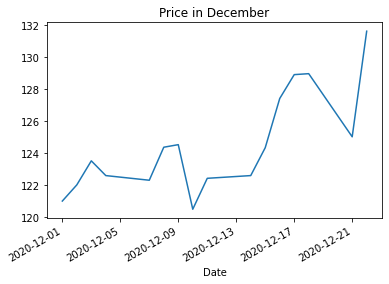

In [13]:
df['2020-12']['Open'].plot(title='Price in December')

In [14]:
# Let's append a new row with max predicted date
#SKIP IT FOR NOW
#obj = {}
#for col in df.columns:
#    obj[col] = [np.nan]
#f = df.append(pd.DataFrame(obj,index=[dt_predict_max]))

In [15]:
# Every feature has NaN (missing values)
# We need to fill in these missing features
df.isna().any()

Close/Last    False
Volume        False
Open          False
High          False
Low           False
dtype: bool

In [16]:
df_dynamic_feat = df_resampled[dynamic_features]

In [17]:
df_dynamic_feat.head()

,Volume,Open,High,Low
Date,,,,
2019-12-23,9.871152e+07,70.132,71.062,70.093
2019-12-24,4.847884e+07,71.172,71.222,70.730
2019-12-25,5.266450e+07,71.033,71.694,70.877
2019-12-26,9.333600e+07,71.205,72.495,71.175
2019-12-27,1.463718e+08,72.780,73.492,72.030


In [18]:
df_dynamic_feat.tail()

,Volume,Open,High,Low
Date,,,,
2020-12-18,1.925415e+08,128.960,129.100,126.120
2020-12-19,2.116398e+08,126.985,127.724,123.610
2020-12-20,1.428517e+08,123.792,126.280,121.619
2020-12-21,1.212516e+08,125.020,128.310,123.449
2020-12-22,1.693518e+08,131.610,134.405,129.650


In [19]:
df_dynamic_feat 

,Volume,Open,High,Low
Date,,,,
2019-12-23,9.871152e+07,70.132,71.062,70.093
2019-12-24,4.847884e+07,71.172,71.222,70.730
2019-12-25,5.266450e+07,71.033,71.694,70.877
2019-12-26,9.333600e+07,71.205,72.495,71.175
2019-12-27,1.463718e+08,72.780,73.492,72.030
...,...,...,...,...
2020-12-18,1.925415e+08,128.960,129.100,126.120
2020-12-19,2.116398e+08,126.985,127.724,123.610
2020-12-20,1.428517e+08,123.792,126.280,121.619


In [20]:
time_series_test = []
time_series_training = []

for t in target_values:
    time_series_test.append(df_resampled[dt_test_range[0]:dt_test_range[1]][t])
    time_series_training.append(df_resampled[dt_train_range[0]:dt_train_range[1]][t])

In [21]:
# Dynamic features are the same for count, registered, casual
dynamic_features_test = df_dynamic_feat [dt_test_range[0]:dt_test_range[1]]
dynamic_features_training = df_dynamic_feat[dt_train_range[0]:dt_train_range[1]]

In [22]:
dynamic_features_test

,Volume,Open,High,Low
Date,,,,
2019-12-23,9.871152e+07,70.132,71.062,70.093
2019-12-24,4.847884e+07,71.172,71.222,70.730
2019-12-25,5.266450e+07,71.033,71.694,70.877
2019-12-26,9.333600e+07,71.205,72.495,71.175
2019-12-27,1.463718e+08,72.780,73.492,72.030
...,...,...,...,...
2020-12-18,1.925415e+08,128.960,129.100,126.120
2020-12-19,2.116398e+08,126.985,127.724,123.610
2020-12-20,1.428517e+08,123.792,126.280,121.619


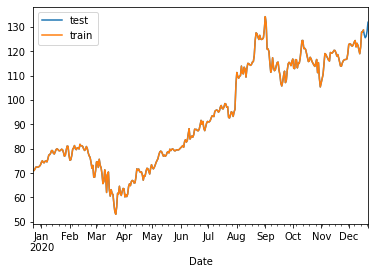

In [23]:
time_series_test[0].plot(label='test')
time_series_training[0].plot(label='train')
plt.legend()
plt.show()

In [24]:
def encode_target(ts):
    return [x if np.isfinite(x) else "NaN" for x in ts]  

def encode_dynamic_feat(dynamic_feat):  
    l = []
    for col in dynamic_feat:
       # assert (not dynamic_feat[col].isna().any()), col  + ' has NaN'             
        l.append(dynamic_feat[col].tolist())
    return l

def series_to_obj(ts, cat=None, dynamic_feat=None):
    obj = {"start": str(ts.index[0]), "target": encode_target(ts)}
    if cat is not None:
        obj["cat"] = cat
    if dynamic_feat is not None:
        obj["dynamic_feat"] = encode_dynamic_feat(dynamic_feat)
    return obj

def series_to_jsonline(ts, cat=None, dynamic_feat=None):
    return json.dumps(series_to_obj(ts, cat, dynamic_feat))   

In [25]:
series_to_jsonline(time_series_training[0][:5], dynamic_feat=dynamic_features_training[:5])

'{"start": "2019-12-23 00:00:00", "target": [71.0, 71.068, 71.808, 72.478, 72.45], "dynamic_feat": [[98711520.0, 48478840.0, 52664503.788, 93336000.0, 146371760.0], [70.132, 71.172, 71.033, 71.205, 72.78], [71.062, 71.222, 71.694, 72.495, 73.492], [70.093, 70.73, 70.877, 71.175, 72.03]]}'

In [26]:
encoding = "utf-8"
with open("train_dynamic_feat.json", 'wb') as fp:
    for ts in time_series_training:
        fp.write(series_to_jsonline(ts,dynamic_feat=dynamic_features_training).encode(encoding))
        fp.write('\n'.encode(encoding))

In [30]:
with open("test_dynamic_feat.json", 'wb') as fp:
    for ts in time_series_test:
        fp.write(series_to_jsonline(ts,dynamic_feat=dynamic_features_test).encode(encoding))
        fp.write('\n'.encode(encoding))

In [31]:
df_resampled.to_csv('all_data_dynamic_feat.csv',index=True,index_label='datetime')

In [32]:
for ts in time_series_test:
    print (len(ts),ts.name)

366 Close/Last


In [33]:
for ts in time_series_training:
    print (len(ts),ts.name)

361 Close/Last
